#  MSCA 37011 - Deep Learning and Image Recognition

## N-Chain Problem

Source: http://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/

In the code below, first the Python module is imported, and then the environment is loaded via the gym.make() command. 

https://gym.openai.com/envs/NChain-v0/

This game presents moves along a linear chain of states, with two actions:

1) Forward, which moves along the chain but returns no reward. The end of the chain, however, presents a large reward, and by moving 'forward' at the end of the chain this large reward can be repeated.
  
2) Backward, which returns to the beginning and has a small reward
        
The first step is to initalize / reset the environment by running env.reset() – this command returns the initial state of the environment – in this case 0. 

There are two possible actions in each state, move forward (action 0) and move backwards (action 1). When action 1 is taken, i.e. move backwards, there is an immediate reward of 2 given to the agent – and the agent is returned to state 0 (back to the beginning of the chain). 

However, when a move forward action is taken (action 0), there is no immediate reward until state 4. When the agent moves forward while in state 4, a reward of 10 is received by the agent. The agent stays in state 4 at this point also, so the reward can be repeated. There is also a random chance that the agent’s action is “flipped” by the environment (i.e. an action 0 is flipped to an action 1 and vice versa). 

<img src="http://adventuresinmachinelearning.com/wp-content/uploads/2018/02/NChain-illustration.png" />

In [1]:
import gym
import numpy as np
env = gym.make('NChain-v0')
env.reset()

0

The first command I then run is env.step(1) – the value in the bracket is the action ID. Action 1 represents a step back to the beginning of the chain (state 0). The step() command returns 4 variables in a tuple, these are (in order):

    The new state after the action
    The reward due to the action
    Whether the game is “done” or not – the NChain game is done after 1,000 steps
    Debugging information – not relevant in this example

In [4]:
env.step(1)

(0, 2, False, {})

In [5]:
env.step(0)

(1, 0, False, {})

Let’s conceptualize a table, and call it a reward table, which looks like this:

$$\begin{bmatrix} 
r_{s_0,a_0} & r_{s_0,a_1} \\ 
r_{s_1,a_0} & r_{s_1,a_1} \\ 
r_{s_2,a_0} & r_{s_2,a_1} \\ 
r_{s_3,a_0} & r_{s_3,a_1} \\ 
r_{s_4,a_0} & r_{s_4,a_1} \\ 
\end{bmatrix}$$

Each of the rows corresponds to the 5 available states in the NChain environment, and each column corresponds to the 2 available actions in each state – forward and backward, 0 and 1. The value in each of these table cells corresponds to some measure of reward that the agent has “learnt” occurs when they are in that state and perform that action. So, the value $r_{s_0,a_0}$ would be, say, the sum of the rewards that the agent has received when in the past they have been in state 0 and taken action 0. 

### A first naive heuristic for reinforcement learning

This table would then let the agent choose between actions based on the summated (or average, median etc. – take your pick) amount of reward the agent has received in the past when taking actions 0 or 1.

This might be a good policy – choose the action resulting in the greatest previous summated reward. Let’s give it a try, the code looks like:

In [6]:
def naive_sum_reward_agent(env, num_episodes=500):
    # this is the table that will hold our summated rewards for
    # each action in each state
    r_table = np.zeros((5, 2))
    for g in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(r_table[s, :]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with highest cummulative reward
                a = np.argmax(r_table[s, :])
            new_s, r, done, _ = env.step(a)
            r_table[s, a] += r
            s = new_s
    return r_table

In the function definition, the environment is passed as the first argument, then the number of episodes (or number of games) that we will train the r_table on. We first create the r_table matrix which I presented previously and which will hold our summated rewards for each state and action. Then there is an outer loop which cycles through the number of episodes. The env.reset() command starts the game afresh each time a new episode is commenced. It also returns the starting state of the game, which is stored in the variable s.

The second, inner loop continues until a “done” signal is returned after an action is passed to the environment. The if statement on the first line of the inner loop checks to see if there are any existing values in the r_table for the current state – it does this by confirming if the sum across the row is equal to 0. If it is zero, then an action is chosen at random – there is no better information available at this stage to judge which action to take.

This condition will only last for a short period of time. After this point, there will be a value stored in at least one of the actions for each state, and the action will be chosen based on which column value is the largest for the row state s. In the code, this choice of the maximum column is executed by the numpy argmax function – this function returns the index of the vector / matrix with the highest value. For example, if the agent is in state 0 and we have the r_table with values [100, 1000] for the first row, action 1 will be selected as the index with the highest value is column 1.

After the action has been selected and stored in a, this action is fed into the environment with env.step(a). This command returns the new state, the reward for this action, whether the game is “done” at this stage and the debugging information that we are not interested in. In the next line, the r_table cell corresponding to state s and action a is updated by adding the reward to whatever is already existing in the table cell.

Finally the state s is updated to new_s – the new state of the agent.

In [7]:
naive_sum_reward_agent(env)

array([[     0., 637084.],
       [     0., 126754.],
       [     0.,  25644.],
       [  1302.,      0.],
       [     0.,  11400.]])

Examining the results above, you can observe that the most common state for the agent to be in is the first state, seeing as any action 1 will bring the agent back to this point. The least occupied state is state 4, as it is difficult for the agent to progress from state 0 to 4 without the action being “flipped” and the agent being sent back to state 0. You can get different results if you run the function multiple times, and this is because of the stochastic nature of both the environment and the algorithm.

Clearly – something is wrong with this table. One would expect that in state 4, the most rewarding action for the agent would be to choose action 0, which would reward the agent with 10 points, instead of the usual 2 points for an action of 1. Not only that, but it has chosen action 0 for all states – this goes against intuition – surely it would be best to sometimes shoot for state 4 by choosing multiple action 0’s in a row, and that way reap the reward of multiple possible 10 scores.

In fact, there are a number of issues with this way of doing reinforcement learning:

1) First, once there is a reward stored in one of the columns, the agent will always choose that action from that point on. This will lead to the table being “locked in” with respect to actions after just a few steps in the game.

2) Second, because no reward is obtained for most of the states when action 0 is picked, this model for training the agent has no way to encourage acting on delayed reward signal when it is appropriate for it to do so.

Let’s see how these problems could be fixed.

### Q-learning

Let’s say we are in state 3 – in the previous case, when the agent chose action 0 to get to state 3, the reward was zero and therefore r_table[3, 0] = 0. Obviously the agent would not see this as an attractive step compared to the alternative for this state i.e. r_table[3, 1] >= 2. But what if we assigned to this state the reward the agent would received if it chose action 0 in state 4? It would look like this: r_table[3, 0] = r + 10 = 10 – a much more attractive alternative!

This idea of propagating possible reward from the best possible actions in future states is a core component of what is called Q learning.

$$Q(s, a) = Q(s, a) + \alpha (r + \gamma \max\limits_{a’} Q(s’, a’) – Q(s, a))$$

In [8]:
def q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95
    lr = 0.8
    for i in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(q_table[s,:]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with largest q value in state s
                a = np.argmax(q_table[s, :])
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr*(y*np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

This function is almost exactly the same as the previous naive r_table function that was discussed. The additions and changes are:

1) The variables y which specifies the discounting factor γ\gamma and lr which is the Q table updating learning rate

2) The line:
       
       q_table[s, a] += r + lr*(y*np.max(q_table[new_s, :]) - q_table[s, a])

In [9]:
q_learning_with_table(env)

array([[ 0.        , 29.72253456],
       [ 0.        , 30.00671718],
       [ 0.        , 31.71115947],
       [ 0.        , 35.97176768],
       [46.81856636,  0.        ]])

This output is strange, isn’t it? Again, we would expect at least the state 4 – action 0 combination to have the highest Q score, but it doesn’t.  We might also expect the reward from this action in this state to have cascaded down through the states 0 to 3. Something has clearly gone wrong – and the answer is that there isn’t enough exploration going on within the agent training method.

### Q learning with ϵ-greedy action selection

If we think about the previous iteration of the agent training model using Q learning, the action selection policy is based solely on the maximum Q value in any given state. It is conceivable that, given the random nature of the environment, that the agent initially makes “bad” decisions. The Q values arising from these decisions may easily be “locked in” – and from that time forward, bad decisions may continue to be made by the agent because it can only ever select the maximum Q value in any given state, even if these values are not necessarily optimal. This action selection policy is called a greedy policy.

So we need a way for the agent to eventually always choose the “best” set of actions in the environment, yet at the same time allowing the agent to not get “locked in” and giving it some space to explore alternatives. What is required is the ϵ\epsilon-greedy policy.

The ϵ\epsilon-greedy policy in reinforcement learning is basically the same as the greedy policy, except that there is a value ϵ\epsilon (which may be set to decay over time) where, if a random number is selected which is less than this value, an action is chosen completely at random. This step allows some random exploration of the value of various actions in various states, and can be scaled back over time to allow the algorithm to concentrate more on exploiting the best strategies that it has found. This mechanism can be expressed in code as:

In [10]:
def eps_greedy_q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95
    eps = 0.5
    lr = 0.8
    decay_factor = 0.999
    for i in range(num_episodes):
        s = env.reset()
        eps *= decay_factor
        done = False
        while not done:
            # select the action with highest cummulative reward
            if np.random.random() < eps or np.sum(q_table[s, :]) == 0:
                a = np.random.randint(0, 2)
            else:
                a = np.argmax(q_table[s, :])
            # pdb.set_trace()
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr * (y * np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

This code shows the introduction of the ϵ value – eps. There is also an associated eps decay_factor which exponentially decays eps with each episode eps *= decay_factor. The ϵ-greedy based action selection can be found in this code

    if np.random.random() < eps or np.sum(q_table[s, :]) == 0:
        a = np.random.randint(0, 2)
    else:
        a = np.argmax(q_table[s, :])
        
        
The first component of the if statement shows a random number being selected, between 0 and 1, and determining if this is below eps. If so, the action will be selected randomly from the two possible actions in each state. The second part of the if statement is a random selection if there are no values stored in the q_table so far. If neither of these conditions hold true, the action is selected as per normal by taking the action with the highest q value.

The rest of the code is the same as the standard greedy implementation with Q learning discussed previously. This code produces a q_table which looks something like the following:

In [11]:
eps_greedy_q_learning_with_table(env)

array([[43.8991201 , 45.11740036],
       [50.77006921, 44.71899353],
       [52.62276882, 46.35874076],
       [49.00020906, 54.85361822],
       [51.94729817, 50.33172889]])

### Comparing the methods

Let’s see if the last agent training model actually produces an agent that gathers the most rewards in any given game. The code below shows the three models trained and then tested over 100 iterations to see which agent performs the best over a test game. The models are trained as well as tested in each iteration because there is significant variability in the environment which messes around with the efficacy of the training – so this is an attempt to understand average performance of the different models. The main testing code looks like:

In [10]:
def run_game(table, env):
    s = env.reset()
    tot_reward = 0
    done = False
    while not done:
        a = np.argmax(table[s, :])
        s, r, done, _ = env.step(a)
        tot_reward += r
    return tot_reward

First, this method creates a numpy zeros array of length 3 to hold the results of the winner in each iteration – the winning method is the method that returns the highest rewards after training and playing. 

In [11]:
def test_methods(env, num_iterations=100):
    winner = np.zeros((3,))
    for g in range(num_iterations):
        m0_table = naive_sum_reward_agent(env, 500)
        m1_table = q_learning_with_table(env, 500)
        m2_table = eps_greedy_q_learning_with_table(env, 500)
        m0 = run_game(m0_table, env)
        m1 = run_game(m1_table, env)
        m2 = run_game(m2_table, env)
        w = np.argmax(np.array([m0, m1, m2]))
        winner[w] += 1
        print("Game {} of {}".format(g + 1, num_iterations))
    return winner

In [12]:
test_methods(env)

Game 1 of 100
Game 2 of 100
Game 3 of 100
Game 4 of 100
Game 5 of 100
Game 6 of 100
Game 7 of 100
Game 8 of 100
Game 9 of 100
Game 10 of 100
Game 11 of 100
Game 12 of 100
Game 13 of 100
Game 14 of 100
Game 15 of 100
Game 16 of 100
Game 17 of 100
Game 18 of 100
Game 19 of 100
Game 20 of 100
Game 21 of 100
Game 22 of 100
Game 23 of 100
Game 24 of 100
Game 25 of 100
Game 26 of 100
Game 27 of 100
Game 28 of 100
Game 29 of 100
Game 30 of 100
Game 31 of 100
Game 32 of 100
Game 33 of 100
Game 34 of 100
Game 35 of 100
Game 36 of 100
Game 37 of 100
Game 38 of 100
Game 39 of 100
Game 40 of 100
Game 41 of 100
Game 42 of 100
Game 43 of 100
Game 44 of 100
Game 45 of 100
Game 46 of 100
Game 47 of 100
Game 48 of 100
Game 49 of 100
Game 50 of 100
Game 51 of 100
Game 52 of 100
Game 53 of 100
Game 54 of 100
Game 55 of 100
Game 56 of 100
Game 57 of 100
Game 58 of 100
Game 59 of 100
Game 60 of 100
Game 61 of 100
Game 62 of 100
Game 63 of 100
Game 64 of 100
Game 65 of 100
Game 66 of 100
Game 67 of 100
Game

array([14., 10., 76.])

Here, it can be observed that the trained table given to the function is used for action selection, and the total reward accumulated during the game is returned. A sample outcome from this experiment (i.e. the vector w) is shown below:
    
        [13, 22, 65]

As can be observed, of the 100 experiments the ϵ-greedy, Q learning algorithm (i.e. the third model that was presented) wins 65 of them. This is followed by the standard greedy implementation of Q learning, which won 22 of the experiments. Finally the naive accumulated rewards method only won 13 experiments. *So as can be seen, the ϵ-greedy Q learning method is quite an effective way of executing reinforcement learning.*

So far, we have been dealing with explicit tables to hold information about the best actions and which actions to choose in any given state. However, while this is perfectly reasonable for a small environment like NChain, the table gets far too large and unwieldy for more complicated environments which have a huge number of states and potential actions.

### RL using Neural Networks in Keras

To develop a neural network which can perform Q learning, the input needs to be the current state (plus potentially some other information about the environment) and it needs to output the relevant Q values for each action in that state. The Q values which are output should approach, as training progresses, the values produced in the Q learning updating rule. Therefore, the loss or cost function for the neural network should be:

$$\text{loss} = (\underbrace{r + \gamma \max_{a’} Q'(s’, a’)}_{\text{target}} – \underbrace{Q(s, a)}_{\text{prediction}})^2$$

<img src = "http://adventuresinmachinelearning.com/wp-content/uploads/2018/03/Reinforcement-learning-Keras.png" width ="50%"/>

The input to the network is the one-hot encoded state vector. For instance, the vector which corresponds to state 1 is [0, 1, 0, 0, 0] and state 3 is [0, 0, 0, 1, 0]. In this case, a hidden layer of 10 nodes with sigmoid activation will be used. The output layer is a linear activated set of two nodes, corresponding to the two Q values assigned to each state to represent the two possible actions. Linear activation means that the output depends only on the linear summation of the inputs and the weights, with no additional function applied to that summation. 

In [13]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Activation

model = Sequential()
model.add(InputLayer(batch_input_shape=(1, 5)))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (1, 10)                   60        
_________________________________________________________________
dense_2 (Dense)              (1, 2)                    22        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


First, the model is created using the Keras Sequential API. Then an input layer is added which takes inputs corresponding to the one-hot encoded state vectors. Then the sigmoid activated hidden layer with 10 nodes is added, followed by the linear activated output layer which will yield the Q values for each action. Finally the model is compiled using a mean-squared error loss function (to correspond with the loss function defined previously) with the Adam optimizer being used in its default Keras state.

To use this model in the training environment, the following code is run which is similar to the previous ϵ\epsilon-greedy Q learning methodology with an explicit Q table:

In [14]:
# now execute the q learning
y = 0.95
eps = 0.5
decay_factor = 0.999
r_avg_list = []
num_episodes = 1000

for i in range(num_episodes):
    s = env.reset()
    eps *= decay_factor
    if i % 100 == 0:
        print("Episode {} of {}".format(i + 1, num_episodes))
    done = False
    r_sum = 0

    while not done:
        if np.random.random() < eps:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(model.predict(np.identity(5)[s:s + 1]))
        new_s, r, done, _ = env.step(a)
        target = r + y * np.max(model.predict(np.identity(5)[new_s:new_s + 1]))
        target_vec = model.predict(np.identity(5)[s:s + 1])[0]
        target_vec[a] = target
        model.fit(np.identity(5)[s:s + 1], target_vec.reshape(-1, 2), epochs=1, verbose=0)
        s = new_s
        r_sum += r

    r_avg_list.append(r_sum / 1000)

Episode 1 of 1000
Episode 101 of 1000
Episode 201 of 1000
Episode 301 of 1000
Episode 401 of 1000
Episode 501 of 1000
Episode 601 of 1000
Episode 701 of 1000
Episode 801 of 1000
Episode 901 of 1000


The first line sets the target as the Q learning updating rule that has been previously presented. *It is the reward r plus the discounted maximum of the predicted Q values for the new state, new_s. This is the value that we want the Keras model to learn to predict for state s and action a i.e. Q(s,a).* However, our Keras model has an output for each of the two actions – we don’t want to alter the value for the other action, only the action a which has been chosen. So on the next line, target_vec is created which extracts both predicted Q values for state s. On the following line, only the Q value corresponding to the action a is changed to target – the other action’s Q value is left untouched.

The final line is where the Keras model is updated in a single training step. The first argument is the current state – i.e. the one-hot encoded input to the model. The second is our target vector which is reshaped to make it have the required dimensions of (1, 2). The third argument tells the fit function that we only want to train for a single iteration and finally the verbose flag simply tells Keras not to print out the training progress.

Running this training over 1000 game episodes reveals the following average reward for each step in the game:

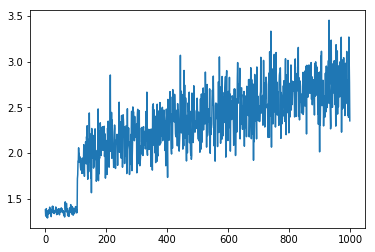

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(r_avg_list)

As can be observed, the average reward per step in the game increases over each game episode, showing that the Keras model is learning well (if a little slowly). We can also run the following code to get an output of the Q values for each of the states – this is basically getting the Keras model to reproduce our explicit Q table that was generated in previous methods:

    State 0 – action [[62.734287 61.350456]]
    State 1 – action [[66.317955 62.27209 ]]
    State 2 – action [[70.82501 63.262383]]
    State 3 – action [[76.63797 64.75874]]
    State 4 – action [[84.51073 66.499725]]

This output looks sensible – we can see that the Q values for each state will favor choosing action 0 (moving forward) to shoot for those big, repeated rewards in state 4. Intuitively, this seems like the best strategy.